In [1]:
import numpy as np
import pandas as pd
import time
import os

In [2]:
def loadCSV(filename):
    file = filename
    if '.csv' not in filename:
        file += '.csv'
    data = pd.read_csv(file, encoding = 'ISO-8859-1')
    return data

In [3]:
def loadNLPVectors(filename):
    file = 'nlp_data/' + filename + '.npy'
    return np.load(file)

In [4]:
def loadLabels():
    return loadNLPVectors("labels")

In [5]:
from sklearn.model_selection import train_test_split
def genData(nlp):
    X_train, X_test, y_train, y_test = train_test_split(nlp, labels,
                                                        test_size = 0.2,
                                                        random_state = 42,
                                                        shuffle = True,
                                                        stratify = labels)
    
    train = [X_train, y_train]
    test = [X_test, y_test]
    
    return train, test

# Load NLP Data

In [6]:
unigram_array = "feature_array_unigram"
bigram_array = "feature_array_bigram"
tfidf_array = "feature_array_tfidf"
wordvec_array = "feature_array_word2vec"
unigram_reduced = "reduced_unigram"
bigram_reduced = "reduced_bigram"
tfidf_reduced = "reduced_tfidf"

In [7]:
unigram = loadNLPVectors(unigram_array)
bigram = loadNLPVectors(bigram_array)
tfidf = loadNLPVectors(tfidf_array)
word2vec = loadNLPVectors(wordvec_array)
reduced_unigram = loadNLPVectors(unigram_reduced)
reduced_bigram = loadNLPVectors(bigram_reduced)
reduced_tfidf = loadNLPVectors(tfidf_reduced)
labels = loadLabels()

# Generate Training and Testing Data

In [8]:
train_uni, test_uni = genData(unigram)

In [9]:
train_big, test_big = genData(bigram)

In [10]:
train_tfidf, test_tfidf = genData(tfidf)

In [11]:
train_vec, test_vec = genData(word2vec)

In [12]:
train_runi, test_runi = genData(reduced_unigram)

In [13]:
train_rbig, test_rbig = genData(reduced_bigram)

In [14]:
train_rtfidf, test_rtfidf = genData(reduced_tfidf)

# Keras - Neural Networks

In [15]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

Limited tf.compat.v2.summary API due to missing TensorBoard installation
Limited tf.summary API due to missing TensorBoard installation


In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [17]:
def plotFigures(hist, epoch_range):
    
    training_loss = hist.history['loss']
    training_acc = hist.history['accuracy']
    
    validation_loss = hist.history['val_loss']
    validation_acc = hist.history['val_accuracy']
    
    epochs = range(1, epoch_range + 1)
    
    f = plt.figure(1)
    plt.title("Training and Validation Loss")
    plt.plot(epochs, training_loss, 'r', label = 'Training Loss')
    plt.plot(epochs, validation_loss, 'b', label = 'Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    g = plt.figure(2)
    plt.title("Training and Validation Accuracy")
    plt.plot(epochs, training_acc, 'r', label = 'Training Acc')
    plt.plot(epochs, validation_acc, 'b', label = 'Validation Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

In [18]:
def evaluate(model, history, test, name):
    X_test = test[0]
    y_test = test[1]
    epoch_range = len(history.history['loss'])
    
    pred_sigmoid = model.predict(X_test)
    pred = []
    for p in pred_sigmoid:
        if p < .5:
            pred.append(0)
        else:
            pred.append(1)
    y_pred = np.asarray(pred)
    
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    f = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    print(name + ' Evaluation: ')
    print('Accuracy:       ', acc)
    print('ROC AUC Score:  ', roc_auc)
    print('F1 Score:       ', f)
    print('Precision:      ', precision)
    print('Recall:         ', recall)
    
    plotFigures(history, epoch_range)

# Generate Sequential Neural Network

In [19]:
def DNN(train, test, iterations = 50, early_stop = False, info = 0):
    X_train = train[0]
    y_train = train[1]
    
    X_test = test[0]
    y_test = test[1]
    
    dim = len(X_train[0])
    
    model = models.Sequential()
    if dim > 10000:
        model.add(layers.Dense(200, kernel_regularizer = l2(.001),
                               activation = 'relu', input_shape = (dim,)))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(32, kernel_regularizer = l2(.001),
                               activation = 'relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(4, kernel_regularizer = l2(.001),
                               activation = 'relu'))
    elif dim == 500:
        model.add(layers.Dense(64, kernel_regularizer = l2(.001),
                               activation = 'relu', input_shape = (dim,)))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(16, kernel_regularizer = l2(.001),
                               activation = 'relu'))
    elif dim == 200:
        model.add(layers.Dense(32, kernel_regularizer = l2(.001),
                               activation = 'relu', input_shape = (dim,)))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(4, kernel_regularizer = l2(.001),
                               activation = 'relu'))
    elif dim == 50:
        model.add(layers.Dense(16, kernel_regularizer = l2(.001),
                               activation = 'relu', input_shape = (dim,)))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(4, kernel_regularizer = l2(.001),
                               activation = 'relu', input_shape = (dim, )))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    
    model.summary()
    model.compile(loss = 'binary_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])
    
    start = time.time()
    
    callback = [EarlyStopping(monitor = 'val_loss', min_delta = .0001)]
    if early_stop:
        history = model.fit(X_train, y_train,
                            epochs = iterations,
                            verbose = info,
                            batch_size = 128,
                            callbacks = callback,
                            validation_data = (X_test, y_test))
    else:
        history = model.fit(X_train, y_train,
                            epochs = iterations,
                            verbose = info,
                            batch_size = 128,
                            validation_data = (X_test, y_test))
        
    end = time.time() - start
    
    test_vals = model.evaluate(X_test, y_test)
    
    print("Training Time:  ", end)
    print("Model Loss:     ", test_vals[0])
    print("Model Accuracy: ", test_vals[1])
    
    return model, history

# Generate Tokenized Data for CNN and RNN

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [21]:
def tokenData():
    tokenizer = Tokenizer()
    encoder = LabelEncoder()
    
    data = loadCSV("binary_classification")
    X_train, X_test, y_train, y_test = train_test_split(data["tweet_text"], data["tweet_class"],
                                                        test_size = 0.2, random_state = 42,
                                                        shuffle = True, 
                                                        stratify = data["tweet_class"])
    
    tokenizer.fit_on_texts(X_train)
    train_seq = tokenizer.texts_to_sequences(X_train)
    test_seq = tokenizer.texts_to_sequences(X_test)
    
    max_train = max([len(x) for x in train_seq])
    max_test = max([len(x) for x in test_seq])
    max_len = max([max_train, max_test])
    
    train_seq_array = pad_sequences(train_seq, maxlen = max_len)
    test_seq_array = pad_sequences(test_seq, maxlen = max_len)
    
    train_label = encoder.fit_transform(y_train)
    test_label = encoder.fit_transform(y_test)
    
    train = [train_seq_array, train_label]
    test = [test_seq_array, test_label]
    
    vocab_size = len(tokenizer.word_index) + 1
    
    return train, test, max_len, vocab_size

# Generate Convolutional Neural Network

In [22]:
def CNN(iterations = 50, early_stop = False, info = 0):
    train, test, max_len, vocab_size = tokenData()

    X_train = train[0]
    y_train = train[1]
    
    X_test = test[0]
    y_test = test[1]
    
    model = models.Sequential()
    model.add(layers.Embedding(input_dim = vocab_size, output_dim = 32, input_length = max_len))
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv1D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(layers.MaxPooling1D(pool_size = 2))
    model.add(layers.Conv1D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4, kernel_regularizer = l2(.001), activation = 'relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    
    
    model.summary()
    model.compile(loss = 'binary_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])
    
    callback = [EarlyStopping(monitor = 'val_loss', min_delta = .0001)]
    
    start = time.time()
    if early_stop:
        history = model.fit(X_train, y_train,
                            epochs = iterations,
                            verbose = info,
                            batch_size = 128,
                            callbacks = callback,
                            validation_data = (X_test, y_test))
    else:
        history = model.fit(X_train, y_train,
                            epochs = iterations,
                            verbose = info,
                            batch_size = 128,
                            validation_data = (X_test, y_test))
    end = time.time() - start
    
    test_vals = model.evaluate(X_test, y_test)
    
    print("Training Time:  ", end)
    print("Model Loss:     ", test_vals[0])
    print("Model Accuracy: ", test_vals[1])
    
    return model, history, test

# Generate Recurrent Neural Network with LSTM

In [23]:
def RNN(iterations = 50, early_stop = False, info = 0):
    train, test, max_len, vocab_size = tokenData()

    X_train = train[0]
    y_train = train[1]
    
    X_test = test[0]
    y_test = test[1]
    
    model = models.Sequential()
    model.add(layers.Embedding(input_dim = vocab_size, output_dim = 64, input_length = max_len))
    model.add(layers.SpatialDropout1D(0.5))
    model.add(layers.LSTM(16, dropout = 0.5, recurrent_dropout = 0.5))
    model.add(layers.Dense(4, kernel_regularizer = l2(.001), activation = 'relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    
    model.summary()
    model.compile(loss = 'binary_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])
    
    callback = [EarlyStopping(monitor = 'val_loss', min_delta = .0001)]
    
    start = time.time()
    if early_stop:
        history = model.fit(X_train, y_train,
                            epochs = iterations,
                            verbose = info,
                            batch_size = 128,
                            callbacks = callback,
                            validation_data = (X_test, y_test))
    else:
        history = model.fit(X_train, y_train,
                            epochs = iterations,
                            verbose = info,
                            batch_size = 128,
                            validation_data = (X_test, y_test))
    end = time.time() - start
    
    test_vals = model.evaluate(X_test, y_test)
    
    print("Training Time:  ", end)
    print("Model Loss:     ", test_vals[0])
    print("Model Accuracy: ", test_vals[1])
    
    return model, history, test

# Training Deep Neural Networks

### DNN Reduced Unigram

In [24]:
dnn_runi, dnn_runi_history = DNN(train_runi, test_runi)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                6432      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 6,569
Trainable params: 6,569
Non-trainable params: 0
_________________________________________________________________
2601/2601 [==============================] - 0s 37us/sample - loss: 0.2635 - accuracy: 0.9104
Training Time:   11.107881784439087
Model Loss:      0.26354717181101067
Model Accuracy:  0.91041905


### DNN Reduced Bigram

In [25]:
dnn_rbig, dnn_rbig_history = DNN(train_rbig, test_rbig)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                32064     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 33,121
Trainable params: 33,121
Non-trainable params: 0
_________________________________________________________________
2601/2601 [==============================] - 0s 43us/sample - loss: 0.3122 - accuracy: 0.9120
Training Time:   13.196370840072632
Model Loss:      0.3122113579078529
Model Accuracy:  0.91195697


### DNN Reduced TFIDF

In [26]:
dnn_rtfidf, dnn_rtfidf_history = DNN(train_rtfidf, test_rtfidf)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                6432      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 132       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 5         
Total params: 6,569
Trainable params: 6,569
Non-trainable params: 0
_________________________________________________________________
2601/2601 [==============================] - 0s 70us/sample - loss: 0.2837 - accuracy: 0.9177
Training Time:   9.841897010803223
Model Loss:      0.2837246946878774
Model Accuracy:  0.91772395


### DNN Word2Vec

In [27]:
dnn_vec, dnn_vec_history = DNN(train_vec, test_vec)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16)                816       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 5         
Total params: 889
Trainable params: 889
Non-trainable params: 0
_________________________________________________________________
2601/2601 [==============================] - 0s 34us/sample - loss: 0.6928 - accuracy: 0.5129
Training Time:   9.342365980148315
Model Loss:      0.6928159305335283
Model Accuracy:  0.51287967


### DNN Unigram

In [28]:
dnn_uni, dnn_uni_history = DNN(train_uni, test_uni)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 200)               2676600   
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                6432      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 132       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 5         
Total params: 2,683,169
Trainable params: 2,683,169
Non-trainable params: 0
____________________________________________

### DNN Bigram

In [29]:
dnn_big, dnn_big_history = DNN(train_big, test_big)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 200)               15962800  
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 32)                6432      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 4)                 132       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 5         
Total params: 15,969,369
Trainable params: 15,969,369
Non-trainable params: 0
__________________________________________

### DNN TFIDF

In [30]:
dnn_tfidf, dnn_tfidf_history = DNN(train_tfidf, test_tfidf)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 200)               2676600   
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 32)                6432      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 4)                 132       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 5         
Total params: 2,683,169
Trainable params: 2,683,169
Non-trainable params: 0
____________________________________________

## Evaluating Deep Neural Networks

DNN Unigram Evaluation: 
Accuracy:        0.9165705497885429
ROC AUC Score:   0.9161881174645511
F1 Score:        0.913234706117553
Precision:       0.9254457050243112
Recall:          0.9013417521704814


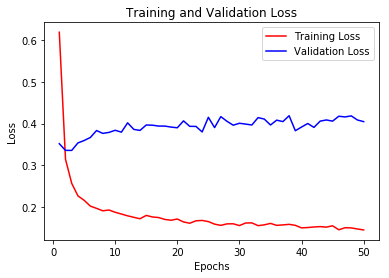

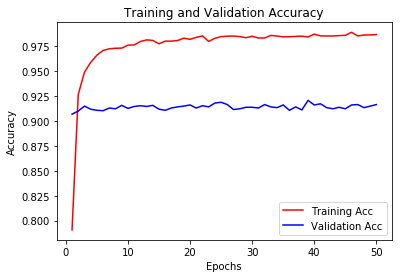

In [31]:
evaluate(dnn_uni, dnn_uni_history, test_uni, 'DNN Unigram')

DNN Bigram Evaluation: 
Accuracy:        0.916955017301038
ROC AUC Score:   0.9164836484677946
F1 Score:        0.913322632423756
Precision:       0.9289795918367347
Recall:          0.8981846882399369


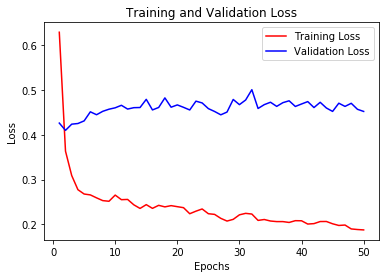

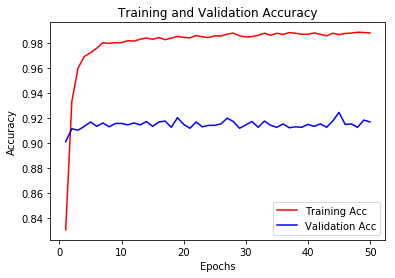

In [32]:
evaluate(dnn_big, dnn_big_history, test_big, 'DNN Bigram')

DNN TFIDF Evaluation: 
Accuracy:        0.9008073817762399
ROC AUC Score:   0.8992549897111429
F1 Score:        0.8917785234899329
Precision:       0.9516562220232766
Recall:          0.8389897395422258


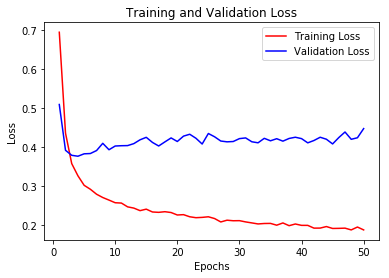

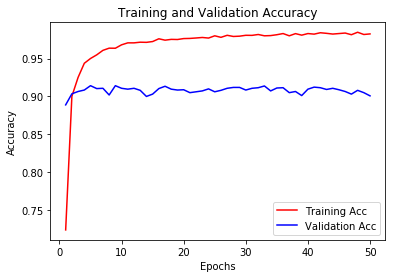

In [33]:
evaluate(dnn_tfidf, dnn_tfidf_history, test_tfidf, 'DNN TFIDF')

DNN Reduced Unigram Evaluation: 
Accuracy:        0.9104190695886197
ROC AUC Score:   0.9092000960845544
F1 Score:        0.9035995035167564
Precision:       0.9495652173913044
Recall:          0.861878453038674


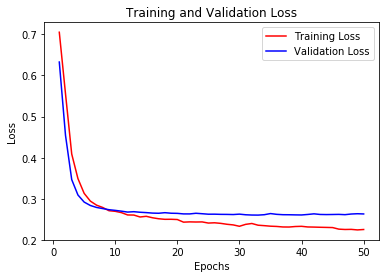

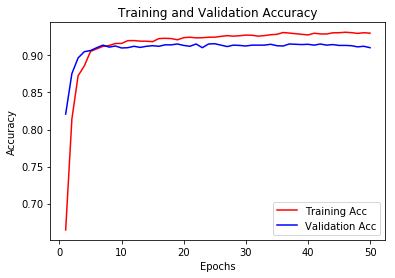

In [34]:
evaluate(dnn_runi, dnn_runi_history, test_runi, 'DNN Reduced Unigram')

DNN Reduced Bigram Evaluation: 
Accuracy:        0.9119569396386006
ROC AUC Score:   0.9111948563997401
F1 Score:        0.9070239545269996
Precision:       0.9339464882943144
Recall:          0.8816101026045777


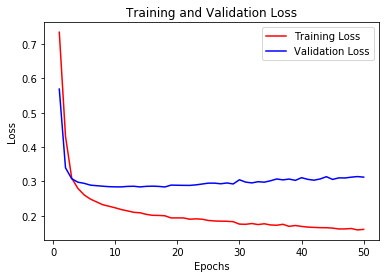

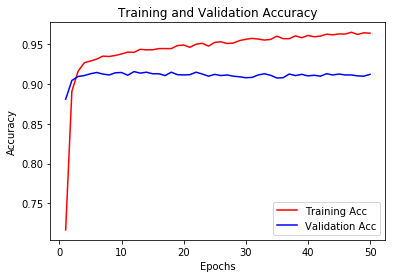

In [35]:
evaluate(dnn_rbig, dnn_rbig_history, test_rbig, 'DNN Reduced Bigram')

DNN Reduced TFIDF Evaluation: 
Accuracy:        0.9177239523260284
ROC AUC Score:   0.9167972249076722
F1 Score:        0.9125102207686017
Precision:       0.9465648854961832
Recall:          0.8808208366219415


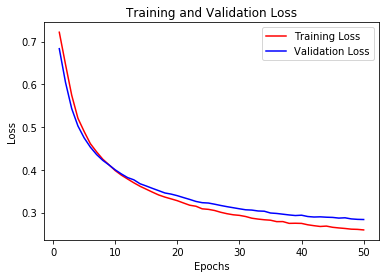

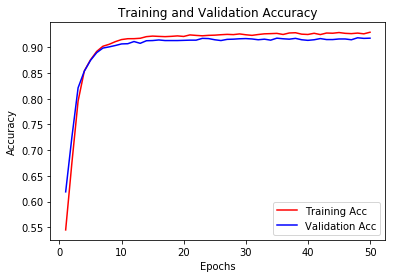

In [36]:
evaluate(dnn_rtfidf, dnn_rtfidf_history, test_rtfidf, 'DNN Reduced TFIDF')

DNN Word2Vec Evaluation: 
Accuracy:        0.512879661668589
ROC AUC Score:   0.5
F1 Score:        0.0
Precision:       0.0
Recall:          0.0


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


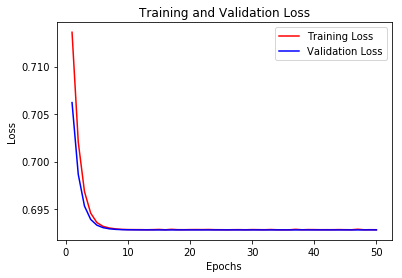

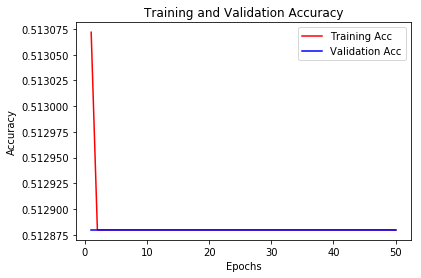

In [37]:
evaluate(dnn_vec, dnn_vec_history, test_vec, 'DNN Word2Vec')

# Training and Evaluating Convolutional Neural Networks

In [38]:
cnn_model, cnn_model_history, test_cnn = CNN()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 22, 32)            377408    
_________________________________________________________________
dropout_10 (Dropout)         (None, 22, 32)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 22, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 16)            1552      
_________________________________________________________________
flatten (Flatten)            (None, 176)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 176)              

Convolutional Neural Network Evaluation: 
Accuracy:        0.8765859284890427
ROC AUC Score:   0.8766129957909758
F1 Score:        0.8738703339882122
Precision:       0.8701095461658842
Recall:          0.877663772691397


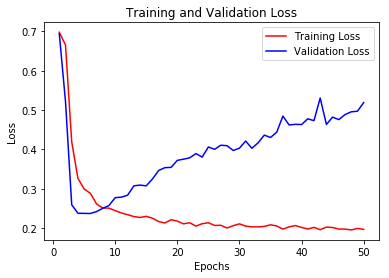

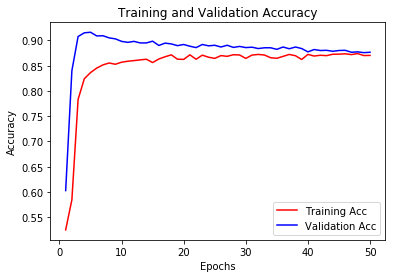

In [39]:
evaluate(cnn_model, cnn_model_history, test_cnn, 'Convolutional Neural Network')

# Training and Evaluating Recurrent Neural Networks

In [40]:
rnn_model, rnn_model_history, test_rnn = RNN()

W1205 04:52:32.230678 4321362816 deprecation.py:506] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:4081: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 22, 64)            754816    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 22, 64)            0         
_________________________________________________________________
unified_lstm (UnifiedLSTM)   (None, 16)                5184      
_________________________________________________________________
dense_26 (Dense)             (None, 4)                 68        
_________________________________________________________________
dropout_13 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 5         
Total params: 760,073
Trainable params: 760,073
Non-trainable params: 0
________________________________________________

Recurrent Neural Network Evaluation: 
Accuracy:        0.896962706651288
ROC AUC Score:   0.8968546508119263
F1 Score:        0.8940711462450591
Precision:       0.8954869358669834
Recall:          0.8926598263614838


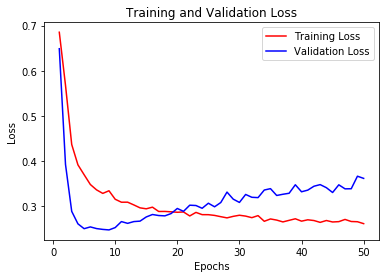

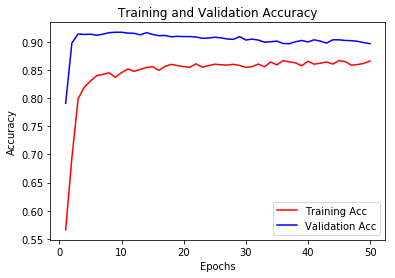

In [41]:
evaluate(rnn_model, rnn_model_history, test_rnn, 'Recurrent Neural Network')

# Training Deep Neural Networks - Early Stopping

### DNN Reduced Unigram

In [43]:
dnn_runi_s, dnn_runi_s_history = DNN(train_runi, test_runi, early_stop = True)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 32)                6432      
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 4)                 132       
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 5         
Total params: 6,569
Trainable params: 6,569
Non-trainable params: 0
_________________________________________________________________
2601/2601 [==============================] - 0s 42us/sample - loss: 0.2692 - accuracy: 0.9131
Training Time:   4.487175941467285
Model Loss:      0.2692464356443507
Model Accuracy:  0.9131103


### DNN Reduced Bigram

In [44]:
dnn_rbig_s, dnn_rbig_s_history = DNN(train_rbig, test_rbig, early_stop = True)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 64)                32064     
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 17        
Total params: 33,121
Trainable params: 33,121
Non-trainable params: 0
_________________________________________________________________
2601/2601 [==============================] - 0s 52us/sample - loss: 0.2809 - accuracy: 0.9154
Training Time:   4.294701099395752
Model Loss:      0.28091625574802903
Model Accuracy:  0.91541713


### DNN Reduced TFIDF

In [45]:
dnn_rtfidf_s, dnn_rtfidf_s_history = DNN(train_rtfidf, test_rtfidf, early_stop = True)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 32)                6432      
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 4)                 132       
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 5         
Total params: 6,569
Trainable params: 6,569
Non-trainable params: 0
_________________________________________________________________
2601/2601 [==============================] - 0s 93us/sample - loss: 0.2920 - accuracy: 0.9127
Training Time:   9.319262027740479
Model Loss:      0.29202809080808084
Model Accuracy:  0.91272587


### DNN Word2Vec

In [46]:
dnn_vec_s, dnn_vec_s_history = DNN(train_vec, test_vec, early_stop = True)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 16)                816       
_________________________________________________________________
dropout_17 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 5         
Total params: 889
Trainable params: 889
Non-trainable params: 0
_________________________________________________________________
2601/2601 [==============================] - 0s 38us/sample - loss: 0.6929 - accuracy: 0.5129
Training Time:   2.805479049682617
Model Loss:      0.6929005690374451
Model Accuracy:  0.51287967


### DNN Unigram

In [47]:
dnn_uni_s, dnn_uni_s_history = DNN(train_uni, test_uni, early_stop = True)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 200)               2676600   
_________________________________________________________________
dropout_18 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 32)                6432      
_________________________________________________________________
dropout_19 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 4)                 132       
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 5         
Total params: 2,683,169
Trainable params: 2,683,169
Non-trainable params: 0
___________________________________________

### DNN Bigram

In [48]:
dnn_big_s, dnn_big_s_history = DNN(train_big, test_big, early_stop = True)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 200)               15962800  
_________________________________________________________________
dropout_20 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 32)                6432      
_________________________________________________________________
dropout_21 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 4)                 132       
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 5         
Total params: 15,969,369
Trainable params: 15,969,369
Non-trainable params: 0
_________________________________________

### DNN TFIDF

In [49]:
dnn_tfidf_s, dnn_tfidf_s_history = DNN(train_tfidf, test_tfidf, early_stop = True)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 200)               2676600   
_________________________________________________________________
dropout_22 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 32)                6432      
_________________________________________________________________
dropout_23 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 4)                 132       
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 5         
Total params: 2,683,169
Trainable params: 2,683,169
Non-trainable params: 0
___________________________________________

# Evaluating Deep Neural Networks - Early Stopping

DNN Unigram - Early Stop Evaluation: 
Accuracy:        0.9115724721261054
ROC AUC Score:   0.9106218398298879
F1 Score:        0.9058919803600655
Precision:       0.9405267629566695
Recall:          0.8737174427782163


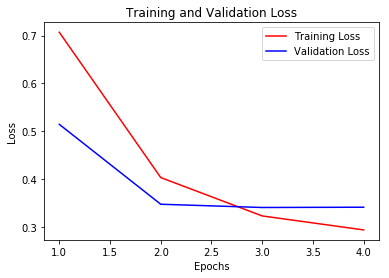

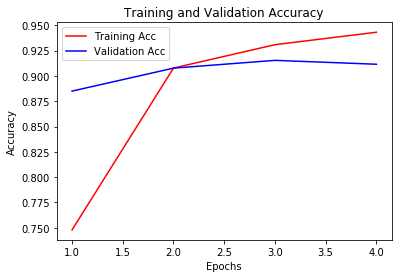

In [50]:
evaluate(dnn_uni_s, dnn_uni_s_history, test_uni, "DNN Unigram - Early Stop")

DNN Bigram - Early Stop Evaluation: 
Accuracy:        0.9131103421760861
ROC AUC Score:   0.9122003717951601
F1 Score:        0.9076797385620916
Precision:       0.9407281964436918
Recall:          0.8768745067087609


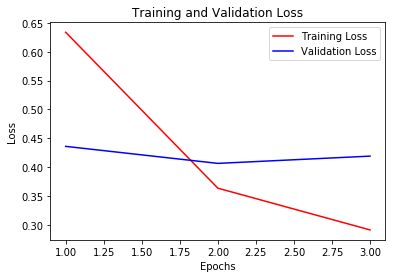

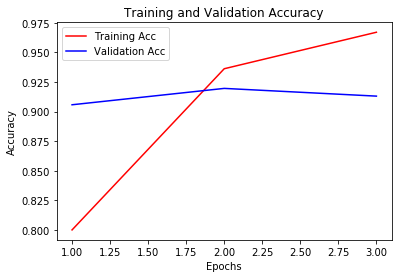

In [51]:
evaluate(dnn_big_s, dnn_big_s_history, test_big, "DNN Bigram - Early Stop")

DNN TFIDF - Early Stop Evaluation: 
Accuracy:        0.9131103421760861
ROC AUC Score:   0.9125571389522288
F1 Score:        0.9090177133655395
Precision:       0.9276910435497124
Recall:          0.8910812943962115


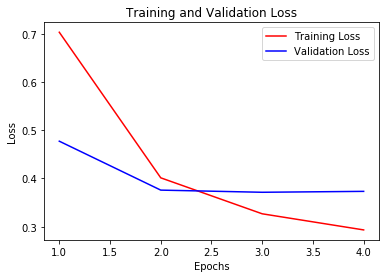

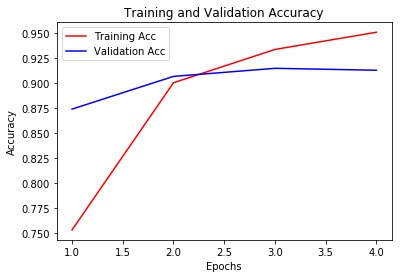

In [52]:
evaluate(dnn_tfidf_s, dnn_tfidf_s_history, test_tfidf, "DNN TFIDF - Early Stop")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


DNN Word2Vec - Early Stop Evaluation: 
Accuracy:        0.512879661668589
ROC AUC Score:   0.5
F1 Score:        0.0
Precision:       0.0
Recall:          0.0


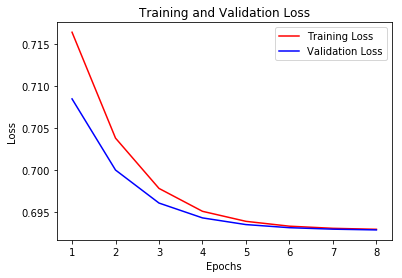

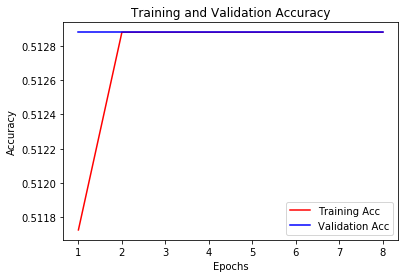

In [53]:
evaluate(dnn_vec_s, dnn_vec_s_history, test_vec, "DNN Word2Vec - Early Stop")

DNN Reduced Unigram - Early Stop Evaluation: 
Accuracy:        0.9131103421760861
ROC AUC Score:   0.9118039638428616
F1 Score:        0.9061461794019934
Precision:       0.9561787905346187
Recall:          0.8610891870560379


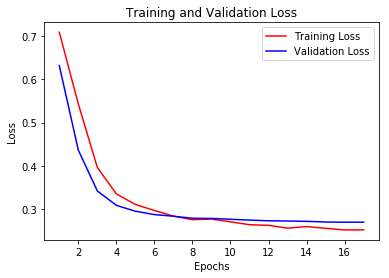

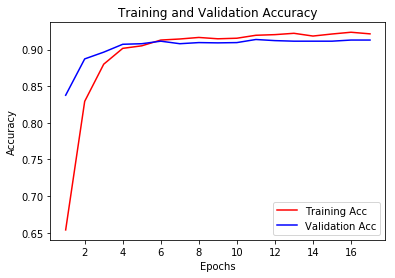

In [54]:
evaluate(dnn_runi_s, dnn_runi_s_history, test_runi, "DNN Reduced Unigram - Early Stop")

DNN Reduced Bigram - Early Stop Evaluation: 
Accuracy:        0.9154171472510573
ROC AUC Score:   0.9145285289478385
F1 Score:        0.9102040816326531
Precision:       0.9425190194420964
Recall:          0.8800315706393055


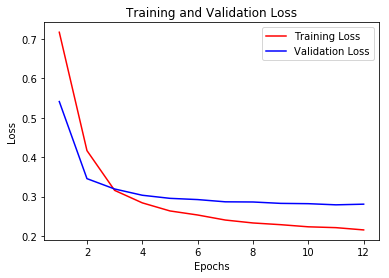

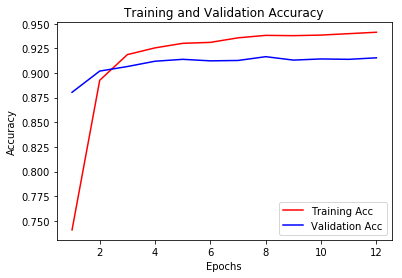

In [55]:
evaluate(dnn_rbig_s, dnn_rbig_s_history, test_rbig, "DNN Reduced Bigram - Early Stop")

DNN Reduced TFIDF - Early Stop Evaluation: 
Accuracy:        0.9127258746635909
ROC AUC Score:   0.9112705880682389
F1 Score:        0.90513999164229
Precision:       0.9618117229129662
Recall:          0.8547750591949487


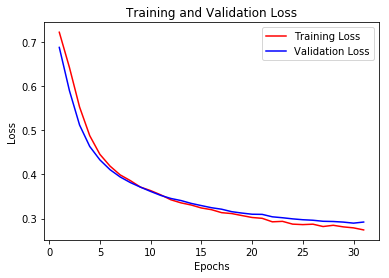

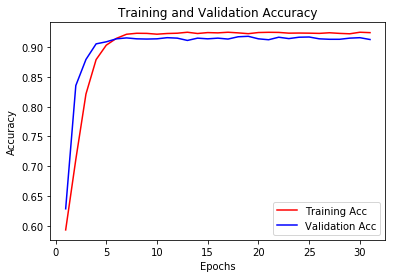

In [56]:
evaluate(dnn_rtfidf_s, dnn_rtfidf_s_history, test_rtfidf, "DNN Reduced TFIDF - Early Stop")

# Training and Evaluating Convolutional Neural Network - Early Stopping

In [57]:
cnn_stop, cnn_stop_history, test_cnn_stop = CNN(early_stop = True)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 22, 32)            377408    
_________________________________________________________________
dropout_24 (Dropout)         (None, 22, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 22, 32)            3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 11, 16)            1552      
_________________________________________________________________
flatten_1 (Flatten)          (None, 176)               0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 176)             

CNN - Early Stop Evaluation: 
Accuracy:        0.9146482122260668
ROC AUC Score:   0.9142545933031905
F1 Score:        0.9112
Precision:       0.9237631792376317
Recall:          0.898973954222573


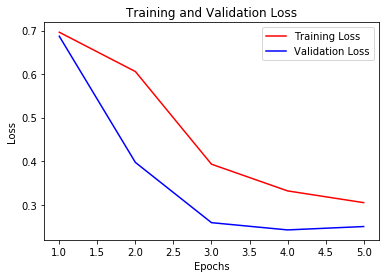

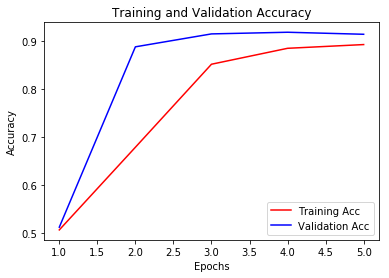

In [58]:
evaluate(cnn_stop, cnn_stop_history, test_cnn_stop, "CNN - Early Stop")

# Training and Evaluating Recurrent Neural Network - Early Stopping

In [59]:
rnn_stop, rnn_stop_history, test_rnn_stop = RNN(early_stop = True)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 22, 64)            754816    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 22, 64)            0         
_________________________________________________________________
unified_lstm_1 (UnifiedLSTM) (None, 16)                5184      
_________________________________________________________________
dense_54 (Dense)             (None, 4)                 68        
_________________________________________________________________
dropout_27 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 5         
Total params: 760,073
Trainable params: 760,073
Non-trainable params: 0
_______________________________________________

RNN - Early Stop Evaluation: 
Accuracy:        0.9123414071510957
ROC AUC Score:   0.9114507466077537
F1 Score:        0.9069387755102041
Precision:       0.9391377852916315
Recall:          0.8768745067087609


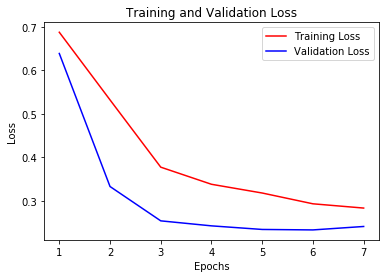

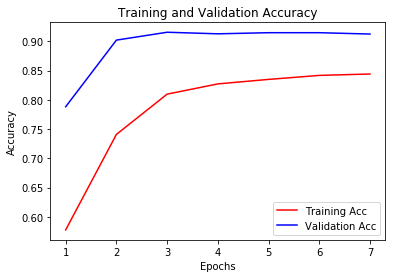

In [60]:
evaluate(rnn_stop, rnn_stop_history, test_rnn_stop, "RNN - Early Stop")